In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1. Prepare the data

Let's get the data ready. Since we're using a **pretrained ResNet-18**, we can't just feed it raw pixels. The model was trained on **ImageNet**, so our CIFAR-10 images need to be "prepped" to look like what the model expects.

### **The Preprocessing Pipeline**

We need to perform three critical steps:

1. **Resize**: ResNet-18 expects $ 224 \times 224 $ images, but CIFAR-10 is only $ 32 \times 32 $. We'll upsample them.
2. **To Tensor**: Convert the images into PyTorch tensors.
3. **Normalize**: We must use the specific Mean and Standard Deviation used during the original ImageNet training:
*  $ Mean : [0.485, 0.456, 0.406] $
*  $ Std : [0.229, 0.224, 0.225] $

---

### **Why Upsampling?**

Because **ResNet-18** was trained on large ImageNet images $ (224 \times 224) $, we need to "resize" the tiny $ 32 \times 32 $ CIFAR images so the pretrained filters can recognize the features.
By resizing $ 32 \times 32 $ up to $ 224 \times 224 $ , the image will look a bit blurry to a human, but for the **ResNet-18 filters**, it ensures that the "features" (like the curve of a car tire or the wing of a plane) align with the sizes the model learned on ImageNet.


In [52]:
# This is the part that actually downloads the 160MB+ CIFAR-10 dataset
# 1. ImageNet-standard normalization and Resizing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Load Datasets (download=True will fetch them into your data/ folder)
train_set = datasets.CIFAR10(
    root='./fine_tuning_pretrained_model/data',       # Path to your local data folder
    train=True, 
    download=True,
    transform=transform
)
test_set = datasets.CIFAR10(
    root='./fine_tuning_pretrained_model/data',
    train=False, 
    download=True,
    transform=transform
)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

/home/p_retrover/github/basic_machine_learning/.venv/lib64/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


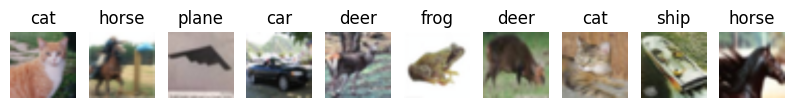

In [53]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 3. Visualization Function
def imshow(img):
    # Un-normalize for viewing
    img = img.clone().detach().cpu().numpy()
    img = img.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get random images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images in a grid
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.show()

# 2. The "Model Surgery"

Now we load the "brain" and modify it. We will "freeze" the weights of the early layers so we don't destroy the pretrained knowledge during the first few epochs.

In [54]:

# 1. Load the Pretrained weights
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2. Freeze all "backbone" layers (Feature Extraction)
# This ensures we don't ruin the pretrained ImageNet knowledge early on
for param in model.parameters():
    param.requires_grad = False

# 3. Modify the final layer (The 'Head')
# ResNet-18's last layer is named 'fc' (Fully Connected)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10) # 10 = Number of CIFAR-10 classes

# 4. Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model surgery complete. Head modified for {num_features} -> 10 classes.")

Model surgery complete. Head modified for 512 -> 10 classes.


In [55]:
# 1. Check if weights are frozen correctly
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {frozen_params + trainable_params:,}")
print(f"Frozen (Pretrained) params: {frozen_params:,}")
print(f"Trainable (New Head) params: {trainable_params:,}")

# 2. Verify the weights are not just zeros or random (Sanity Check)
# We look at the first layer's weights. If they are very small and structured, 
# they are likely the pretrained ImageNet filters.
first_layer_weights = next(model.parameters())
print(f"\nMean value of first layer weights: {first_layer_weights.mean().item():.6f}")

if frozen_params > trainable_params and abs(first_layer_weights.mean().item()) > 1e-7:
    print("✅ SUCCESS: Pretrained weights are loaded and the backbone is frozen.")
else:
    print("⚠️ WARNING: The model might be using random weights or the backbone is not frozen.")

Total parameters: 11,181,642
Frozen (Pretrained) params: 11,176,512
Trainable (New Head) params: 5,130

Mean value of first layer weights: 0.000029
✅ SUCCESS: Pretrained weights are loaded and the backbone is frozen.


### **Next: Setting up the Loss & Optimizer**

Now that the data is flowing, we need to define how the model will learn. We'll use **Cross-Entropy Loss** and the **Adam Optimizer**. Because we are doing "Feature Extraction" first, we will only tell the optimizer to update the weights of the **final layer**.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Only train the head

def train_model(epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1} - Loss: {running_loss/len(train_loader):.4f}")

train_model()

In [ ]:
# 1. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()

# Only optimize parameters that require gradients (the 'head')
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# 2. [Bonus] Learning Rate Scheduler
# This decays the learning rate by a factor of 0.1 every 7 epochs
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    train_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad() # Reset gradients
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            running_loss += loss.item() * inputs.size(0)
        
        # Step the scheduler
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        
        print(f'Epoch {epoch}/{num_epochs - 1} | Loss: {epoch_loss:.4f} | LR: {scheduler.get_last_lr()[0]}')

    return train_loss_history

# Start Training
loss_history = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10)

NameError: name 'trainloader' is not defined